# FixMatch for Semi-Supervised Learning
> pytorch implementation of FixMatch paper as a fastai callback
- toc: false
- badges: false
- comments: false
- categories: [semi-supervised]

This work is ported from FixMatch pytorch implementation [repo](https://github.com/kekmodel/FixMatch-pytorch) by Jungdae Kim. For more details about FixMatch, have a look at this excellent blog post [The Illustrated FixMatch for Semi-Supervised Learning](https://amitness.com/2020/03/fixmatch-semi-supervised/). FixMatch paper can be found [here](https://arxiv.org/abs/2001.07685).

Below is a snapshot from the paper that shows how to handle unlabeled images.  

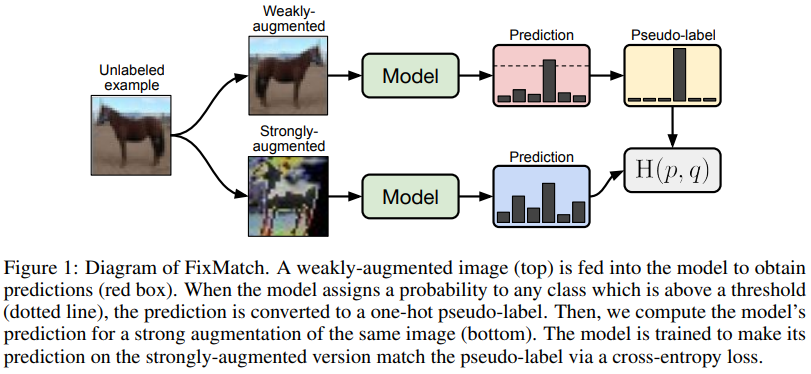


To use this callback you need:  
- A FixMatchTransform: This is a transform that performs weak and strong augmentations on each of the unlabeled images as shown above. This can be used when creating the dataset. 

- A pytorch dataloader for the transformed unlabeled images. This dataloader is passed to the `FixMatch` callback.

In this implementation, FixMatchTransform utilizes `rand_augment_transform` from *timm* library.

In [ ]:
from timm.data.auto_augment import rand_augment_transform

rand_aug = rand_augment_transform(
    config_str='rand-m9-mstd0.5', 
    hparams={})

In [ ]:
class FixMatchTransform():
    def __init__(self, mean, std):
        self.weak = transforms.Compose([transforms.RandomHorizontalFlip()])
        self.strong = rand_aug
        self.normalize = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

Create the unlabeled dataset. STL-10 dataset will be used throughout this example.

In [ ]:
stl10_mean = (0.4914, 0.4822, 0.4465)
stl10_std = (0.2471, 0.2435, 0.2616)

unlabeled_dataset = torchvision.datasets.STL10(root='/kaggle/input/stl10/', split='unlabeled', 
                                               transform=FixMatchTransform(stl10_mean,stl10_std))

In [ ]:
batch_size = 64
mu = 7

Next, we create the dataloader

In [ ]:
unlabeled_trainloader = torch.utils.data.DataLoader(
        unlabeled_dataset,
        batch_size=batch_size*mu,
        shuffle=True,
        drop_last=True)

Below is the FixMatch callback.

In [ ]:
class FixMatch(Callback):
    
    run_valid = False
    
    def __init__(self, unlabeled_trainloader, threshold=0.95, lambda_u=1.0, T=1.0):
        self.unlabeled_trainloader = unlabeled_trainloader
        self.unlabeled_iter = iter(self.unlabeled_trainloader)
        self.threshold = threshold
        self.lambda_u = lambda_u
        self.T = T
        
    def before_train(self):
        self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf
    
    def after_train(self):
        self.learn.loss_func = self.old_lf
        
    def before_batch(self):
        try:
            (self.inputs_u_w, self.inputs_u_s), _ = self.unlabeled_iter.next()
        except:
            self.unlabeled_iter = iter(self.unlabeled_trainloader)
            (self.inputs_u_w, self.inputs_u_s), _ = self.unlabeled_iter.next()
        self.inputs_u_w, self.inputs_u_s = to_device(self.inputs_u_w),to_device(self.inputs_u_s)
        self.learn.xb = tuple(L(torch.cat((self.learn.xb[0], self.inputs_u_w, self.inputs_u_s))))
        
    def after_pred(self):
        self.logits_x = self.pred[:self.dls.train.bs]
        self.logits_u_w, self.logits_u_s = self.pred[self.dls.train.bs:].chunk(2)
        
    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        Lx = self.old_lf(self.logits_x, *yb)
        pseudo_label = torch.softmax(self.logits_u_w.detach()/self.T, dim=-1)
        max_probs, targets_u = torch.max(pseudo_label, dim=-1)
        mask = max_probs.ge(self.threshold).float()
        with NoneReduce(self.old_lf) as lf:
            uloss = lf(self.logits_u_s, targets_u) * mask
        Lu = reduce_loss(uloss, 'mean')
        return Lx + self.lambda_u * Lu

Finally, we construct the callback and pass it to the learner. 

In [ ]:
learn = Learner(dls, model, metrics=accuracy, loss_func=CrossEntropyLossFlat(), opt_func=SGD, 
                cbs=[FixMatch(unlabeled_trainloader)])

From here we follow the standard procedure for training

In [ ]:
learn.fit_one_cycle(3, 3e-2)